# CST 383 – Intro to Data Science
### Project 2: Predicting Kickstarter Goal Completion
**Authors:** Brianna Magallon, Tyler Pruitt, Rafael L.S. Reis

## Introduction
In this project, we use the Kickstarter Projects dataset to build a model that predicts whether a crowdfunding campaign will succeed or fail based on information available at launch. Each entry includes metadata such as goal amount, number of backers, campaign duration, and category.

We treat this as a binary classification problem, where the outcomes are `'successful'` or `'failed'`. We merge `'canceled'` campaigns into the `'failed'` category, based on the observation that they typically don't meet funding goals.

**Dataset Source:**  
[Kickstarter Projects (Kaggle)](https://www.kaggle.com/datasets/kemical/kickstarter-projects)

In [71]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [73]:
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = 5,3

## Data Exploration

In [76]:
df = pd.read_csv("ks-projects-201612.csv", encoding="cp1252", low_memory=False)

In [77]:
df.columns = df.columns.str.strip()
df.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
293041,815887079,HELP MAKE A NEW CULT-CLASSIC FILM,Film & Video,Film & Video,USD,2011-10-04 06:44:33,10000,2011-09-04 06:44:33,10,failed,1,US,10,NaN,NaN,NaN,NaN
307057,899681739,TO THE KING!,Tabletop Games,Games,USD,2015-03-11 23:09:31,400,2015-02-10 00:09:31,1,failed,1,US,1,NaN,NaN,NaN,NaN
125522,1745471739,Becoming of Plus Size,People,Photography,USD,2015-11-12 02:18:07,2000,2015-09-13 02:18:07,0,failed,0,US,0,NaN,NaN,NaN,NaN
219679,375310741,Legalize It Now 100% Hemp Fabric Snapback Hats,Apparel,Fashion,USD,2016-07-25 19:47:28,17500,2016-06-25 19:47:28,26,failed,2,US,25,NaN,NaN,NaN,NaN
311012,923498291,"""In A House Upside Down"" EP",Music,Music,USD,2013-03-19 19:44:32,1000,2013-03-08 20:44:32,21,failed,2,US,21,NaN,NaN,NaN,NaN


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323751 entries, 0 to 323750
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             323751 non-null  object 
 1   name           323747 non-null  object 
 2   category       323745 non-null  object 
 3   main_category  323750 non-null  object 
 4   currency       323750 non-null  object 
 5   deadline       323750 non-null  object 
 6   goal           323750 non-null  object 
 7   launched       323750 non-null  object 
 8   pledged        323750 non-null  object 
 9   state          323750 non-null  object 
 10  backers        323750 non-null  object 
 11  country        323750 non-null  object 
 12  usd pledged    319959 non-null  object 
 13  Unnamed: 13    625 non-null     object 
 14  Unnamed: 14    12 non-null      object 
 15  Unnamed: 15    4 non-null       object 
 16  Unnamed: 16    1 non-null       float64
dtypes: float64(1), object(16)
mem

In [79]:
df['state'].value_counts()

state
failed        168220
successful    113081
canceled       32354
live            4428
undefined       3555
               ...  
2312               1
320                1
477                1
1404               1
2634               1
Name: count, Length: 410, dtype: int64

In [84]:
df[df['state'] == "canceled"].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
7,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29 18:14:43,125000,2014-04-24 18:14:43,8233,canceled,58,US,8233,NaN,NaN,NaN,NaN
8,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10 21:55:48,65000,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,NaN,NaN,NaN,NaN
59,1000256760,"Raise the Woof, expanding the love (Canceled)",Design,Design,CAD,2015-08-07 21:46:53,15000,2015-07-08 21:46:53,700,canceled,6,CA,553.324254,NaN,NaN,NaN,NaN
61,1000260691,Gizbee Unlimited Removable Storage for Your T...,Gadgets,Technology,USD,2016-03-25 19:30:27,87000,2016-02-29 20:30:27,2030,canceled,15,US,2030,NaN,NaN,NaN,NaN


In [86]:
df['country'].value_counts()

country
US      257564
GB       27509
CA       11992
AU        6236
N,"0      3790
         ...  
582          1
26           1
27           1
136          1
176          1
Name: count, Length: 162, dtype: int64

In [88]:
dftest = df[df['country'] == 'US']
dftest = dftest.drop(columns=["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16"])

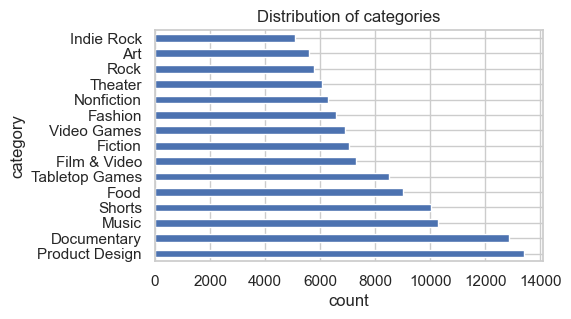

In [108]:
category_counts = dftest['category'].value_counts().head(15)
category_counts.plot.barh()
plt.title('Distribution of categories')
plt.xlabel('count')
plt.ylabel('category')
plt.show()

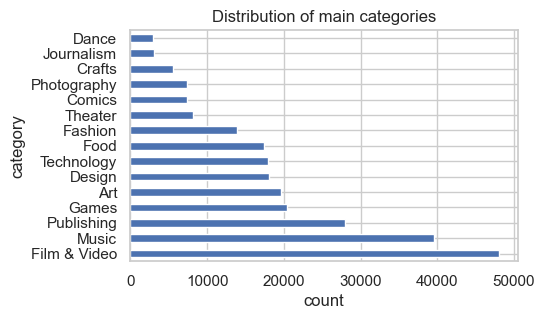

In [110]:
main_category_count = dftest['main_category'].value_counts()
main_category_count.plot.barh()
plt.title('Distribution of main categories')
plt.xlabel('count')
plt.ylabel('category')
plt.show()

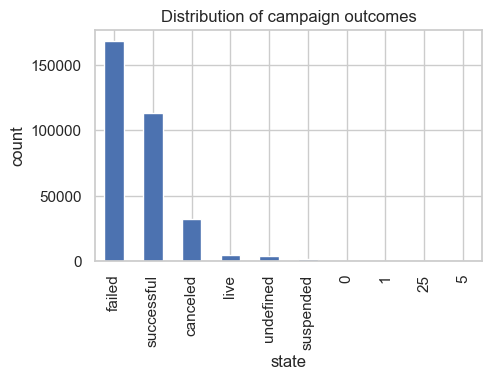

In [112]:
state_counts = df['state'].value_counts().head(10)
state_counts.plot.bar()
plt.title('Distribution of campaign outcomes')
plt.xlabel('state')
plt.ylabel('count')
plt.show()

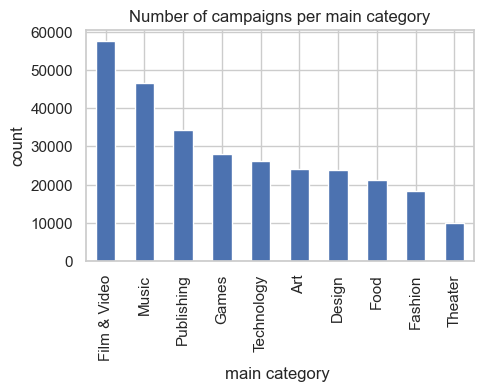

In [114]:
df['main_category'].value_counts().head(10).plot.bar()
plt.title("Number of campaigns per main category")
plt.xlabel("main category ")
plt.ylabel("count")
plt.show()

## Data Cleaning & Preprocessing

We begin cleaning by dropping empty or irrelevant columns and filtering to U.S.-based projects.

In [117]:
df = df.drop(columns=["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16"])

In [119]:
df[df.isnull().any(axis=1)].sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
214832,346741277,"David dBrain ""Odds Get Even"" Album",Music,Music,USD,2015-12-31 15:15:40,3300,2015-12-01 15:15:40,0,undefined,0,"N,""0",NaN
14001,1082350679,This Is Harold follow up album,Music,Music,CAD,2015-08-12 19:25:42,3500,2015-07-13 19:25:42,50,undefined,0,"N,""0",NaN
320578,980818477,Studio J Mobile Recording,Music,Music,USD,2016-01-15 21:23:15,3500,2015-12-01 21:23:15,0,undefined,0,"N,""0",NaN
251287,564599079,Thinking Plague - new CD for 2016,Music,Music,USD,2015-09-12 21:50:34,8000,2015-08-13 21:50:34,8634.78,undefined,0,"N,""0",NaN
53425,1317117360,It's time for my 1st EP - and I need your help!,Music,Music,GBP,2016-05-05 13:25:47,750,2016-04-05 13:25:47,935,successful,0,"N,""0",NaN


In [121]:
df = df[df['state'].isin(["successful", "failed", "canceled"])]

In [123]:
print("Rows still with null values: ", len(df[df.isnull().any(axis=1)]))
df[df.isnull().any(axis=1)].sample(5)

Rows still with null values:  235


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
118856,170560478,Original Album - A Small Bird Drifting in Tire...,Music,Music,USD,2016-05-21 00:56:44,2000,2016-04-21 00:56:44,190,failed,0,"N,""0",NaN
11170,1065249597,SCiO: Your Sixth Sense. A Pocket Molecular Sen...,Hardware,Technology,USD,2014-06-15 21:00:00,200000,2014-04-29 17:18:03,2762571.78,successful,0,"N,""0",NaN
104630,1621451831,Eli and His Demon - A Short Film,Film & Video,Film & Video,USD,2016-05-16 19:51:27,7000,2016-04-11 19:51:27,682,failed,0,"N,""0",NaN
289518,794535445,NLRU,Music,Music,EUR,2016-05-08 20:13:05,5000,2016-04-08 20:13:05,0,failed,0,"N,""0",NaN
4799,1028691308,Help BETHANY record a NEW single in Nash!,Music,Music,USD,2016-05-08 22:37:00,3500,2016-04-04 23:32:00,3502.13,successful,0,"N,""0",NaN


The majority of rows with null values are music or film projects with 0 backers and questionable labels. There's probably a starving artist joke somewhere in there. These rows are minimal (~127), so we drop them.

In [126]:
df = df.dropna()
len(df[df.isnull().any(axis=1)])  # confirm
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313420 entries, 0 to 323750
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ID             313420 non-null  object
 1   name           313420 non-null  object
 2   category       313420 non-null  object
 3   main_category  313420 non-null  object
 4   currency       313420 non-null  object
 5   deadline       313420 non-null  object
 6   goal           313420 non-null  object
 7   launched       313420 non-null  object
 8   pledged        313420 non-null  object
 9   state          313420 non-null  object
 10  backers        313420 non-null  object
 11  country        313420 non-null  object
 12  usd pledged    313420 non-null  object
dtypes: object(13)
memory usage: 33.5+ MB


In [128]:
df['backers'].info()

<class 'pandas.core.series.Series'>
Index: 313420 entries, 0 to 323750
Series name: backers
Non-Null Count   Dtype 
--------------   ----- 
313420 non-null  object
dtypes: object(1)
memory usage: 4.8+ MB


We now correct numeric fields and focus on U.S. projects. Some columns have numeric values stored as strings, so we convert them. This helps avoid bugs later.

In [131]:
df['goal'] = pd.to_numeric(df['goal'], errors='coerce').astype(int)
df.dropna(subset=['goal'], inplace=True)
print(df['goal'])

0          1000
1         45000
2          5000
3         19500
4         50000
          ...  
323746    50000
323747     1500
323748    15000
323749    15000
323750     2000
Name: goal, Length: 313420, dtype: int32


In [133]:
df = df[df['country'] == 'US']
df = df.drop(columns=["usd pledged"])

We convert string dates to datetime, compute duration, and encode labels for our classification model. We also merge `canceled` with `failed`, since both don't meet funding goals — canceled ones just end early.

In [136]:
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])
df['duration_days'] = (df['deadline'] - df['launched']).dt.days

df['state'] = df['state'].replace('canceled', 'failed')
df = df[df['state'].isin(['failed', 'successful'])].copy()
df['state_encoded'] = df['state'].map({'failed': 1, 'successful': 0})

numeric_cols = ['goal', 'pledged', 'backers', 'pledged']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['launch_day'] = df['launched'].dt.day
df['launch_month'] = df['launched'].dt.month

df = df.drop(columns=['ID', 'launched', 'deadline', 'state', 'country', 'currency', 'pledged'])

We are dropping these columns for a variey of reasons. In the case of ID, country, and currency. The contained information is not necessary for predictions as we are focusing on projects in the US, which all use the same currency. We are replacing state with "state_encoded" making the original unecessary. Finally, pledged isn't helpful for the sake of prediction due to the fact that it directly tells the end result, making it useless for the sake of predicting the result.

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253851 entries, 1 to 323750
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           253851 non-null  object
 1   category       253851 non-null  object
 2   main_category  253851 non-null  object
 3   goal           253851 non-null  int32 
 4   backers        253851 non-null  int64 
 5   duration_days  253851 non-null  int64 
 6   state_encoded  253851 non-null  int64 
 7   launch_day     253851 non-null  int32 
 8   launch_month   253851 non-null  int32 
dtypes: int32(3), int64(3), object(3)
memory usage: 16.5+ MB


In [141]:
df.sample(5)

,name,category,main_category,goal,backers,duration_days,state_encoded,launch_day,launch_month
9002,Official YoungDelta Music Fundraiser,Music,Music,5000,2,60,1,20,5
216477,Libretto's Third Album!,Indie Rock,Music,6320,0,60,1,19,7
248247,Write For Life (Canceled),Documentary,Film & Video,15000,20,31,1,18,8
236696,the Pickle Stool,Sculpture,Art,50000,1,40,1,27,8
260418,"A contemporary musical adaptation of ""A TALE O...",Theater,Theater,150000,0,90,1,11,6


## Machine Learning

We define our features and target, then apply a baseline and two models. We'll compare their performance to understand how well basic models do on this problem.

In [154]:
X = df[['goal', 'backers', 'duration_days','launch_day','launch_month']]
y = df['state_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_pred_baseline))

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Baseline accuracy: 0.6240964330030924
Logistic Regression accuracy: 0.9002383250280672
              precision    recall  f1-score   support

           0       0.92      0.80      0.86     19085
           1       0.89      0.96      0.92     31686

    accuracy                           0.90     50771
   macro avg       0.91      0.88      0.89     50771
weighted avg       0.90      0.90      0.90     50771

KNN accuracy: 0.9166453290264127
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     19085
           1       0.94      0.93      0.93     31686

    accuracy                           0.92     50771
   macro avg       0.91      0.91      0.91     50771
weighted avg       0.92      0.92      0.92     50771



Both models beat the baseline, but KNN appears to be overfitting. More work is needed to improve generalization.

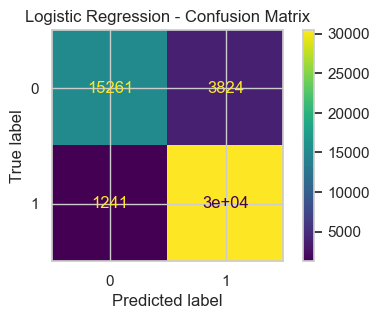

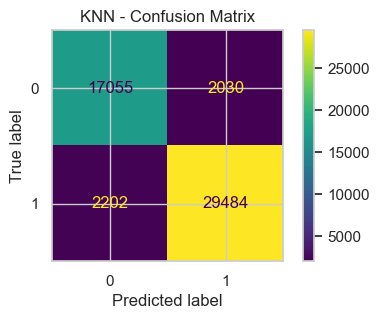

In [156]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.title("KNN - Confusion Matrix")
plt.show()

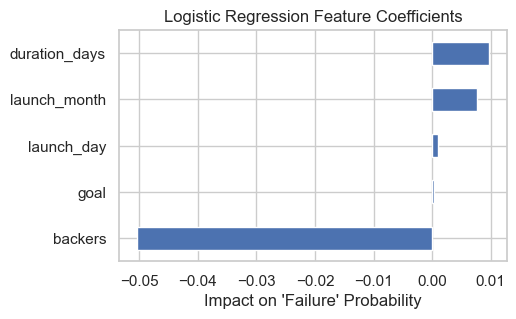

In [158]:
coeffs = pd.Series(logreg.coef_[0], index=X.columns)
coeffs.sort_values().plot(kind='barh')
plt.title("Logistic Regression Feature Coefficients")
plt.xlabel("Impact on 'Failure' Probability")
plt.show()

The feature coefficients are helpful for interpretation. Backers and pledged amount seem to be the strongest predictors.

In [150]:
df.drop(columns=['backers']).sample(5)

,name,category,main_category,goal,duration_days,state_encoded,launch_day,launch_month
252616,The Philanthropist's Stone: Adventures in the ...,Nonfiction,Publishing,15000,22,1,24,12
312014,South Florida Jubilee's Holiday Spectacular Co...,Music,Music,500,40,0,24,10
151340,"Odie Snacks, because little pigs love treats to.",Food,Food,5400,30,1,10,3
219421,The Rigid Flex the safer easier to handle cabl...,Product Design,Design,20000,30,1,25,1
13889,Sincerely Audacious Situational Surrealism,Painting,Art,2500,30,1,5,8


## Conclusion

This project demonstrates the potential of using simple machine learning models to predict Kickstarter campaign outcomes based on basic project metadata. While we achieved accuracy improvements over a baseline dummy classifier, the models are still far from production-ready.

We found that:
- **Logistic Regression** provided reasonable performance and interpretable coefficients, highlighting the importance of features like number of backers and pledged amount.
- **K-Nearest Neighbors** appeared to overfit the training data, performing well on training but less effectively on the test set.
- Both models, while better than guessing the majority class, still left substantial room for improvement.

### Challenges & Next Steps:
- The overfitting observed, especially in KNN, suggests a need for perhaps **feature scaling**, **regularization**, or **simplification**.
- We haven’t yet made use of potentially informative categorical features like main_category or category.
- Adding **cross-validation**, **feature engineering**, and testing other models (e.g., decision trees, gradient boosting) would be valuable next steps.

While this was a solid start, there’s still a lot of work ahead to build a robust and generalizable model. That said, we're excited to dive into model tuning and optimization since this is the part we all find most engaging. The data cleaning process was a bit frustrating and a bit of a pain sometimes... so we're glad to have made it through that and can now focus on the fun side of machine learning :)



(I know we might do some more cleaning stuff, but we're mostly done with that)